# Labolatorium 3

### Autorzy:
Patryk Klatka \
Wojciech Łoboda

### Rekurencyjna kompresja macierzy z wykorzystaniem SVD

Rekurencyjna kompresja macierzy polega na przechowaniu macierzy w strukturze drzewa. Każdy węzeł odpowiada pewniej części macierzy i może być liściem lub posiadać czworo dzieci (reprezentują ćwiartki macierzy), korzeń reprezentuje całą macierz. Liść drzewa reprezentuje macierz skompresowaną za pomocą SVD lub blok zerowy. Decyzja o stworzeniu liścia podejmowana jest na podstawie warunku dopuszczalności ($ Sigma[r] < \epsilon $). 

### SVD
Każdą macierz rzeczywistą $A$ można przedstawić w postaci rozkładu SVD: 
$A = U \Sigma V^T$, gdzie $U$ i $V$ to pewne macierze ortogonalne a $\Sigma$ to macierz diagonalna, która na przekątnej ma nieujemne wartości szczególne macierzy $A$.

Truncated SVD to wersja w której maksymalny rozmiar $\Sigma$ jest podany a pozostałe wartości szczególne są ignorowane.

### Pseudokod

* v - aktualnie rozpatrywany węzeł.
* A - kompresowana macierz.
* t_min, t_max, s_min, s_max - zakresy wierszy i kolumn dla węzła.
* r, $\epsilon$ - parametry kompresji.

Kroki kompresji (wywołanie compress(v)):

* ($U$, $\Sigma$, $V$) = truncatedSVD(A[t_min:t_max, s_min:s_max], r + 1)
* IF ($\Sigma[r, r] < \epsilon$) THEN:
    * aktualny węzeł zostaje liściem, zapisanie $U, \Sigma, V$.
* ELSE:
    * t_newmax = (t_min + t_max) / 2.
    * s_newmax = (s_min + s_max) / 2.
    * v.children[0] = create_node($A$, t_min, t_newmax, s_min, s_newmax), compress(v.children[0]).
    * v.children[1] = create_node($A$, t_min, t_newmax, s_newmax, s_max), compress(v.children[1]).
    * v.children[2] = create_node($A$, t_newmax, t_max, s_min, s_newmax), compress(v.children[2]).
    * v.children[3] = create_node($A$, t_newmax, t_max, s_newmax, s_max), compress(v.children[3]).

In [331]:
from sklearn.utils.extmath import randomized_svd
import numpy as np

class MatrixTree:
    def __init__(self, matrix, row_min, row_max, col_min, col_max):
        self.matrix = matrix
        self.row_min = row_min
        self.row_max = row_max
        self.col_min = col_min
        self.col_max = col_max
        self.leaf = False
        self.children = None


    def compress(self, r, eps):
        U, Sigma, V = randomized_svd(self.matrix[self.row_min:self.row_max, self.col_min: self.col_max], n_components=r+1, random_state=0)
        if self.row_min + r == self.row_max or Sigma[r] <= eps:
            self.leaf = True
            if not self.matrix[self.row_min:self.row_max, self.col_min: self.col_max].any():
                self.rank = 0
            else:
                self.rank = len(Sigma)
                self.u = U
                self.s = Sigma
                self.v = V
        else:
            self.children = []
            row_newmax = (self.row_min + self.row_max)//2
            col_newmax = (self.col_min + self.col_max)//2
            self.children.append(MatrixTree(self.matrix, self.row_min, row_newmax, self.col_min, col_newmax))
            self.children.append(MatrixTree(self.matrix, self.row_min, row_newmax, col_newmax, self.col_max))
            self.children.append(MatrixTree(self.matrix, row_newmax, self.row_max, self.col_min, col_newmax))
            self.children.append(MatrixTree(self.matrix, row_newmax, self.row_max, col_newmax, self.col_max))

            for child in self.children:
                child.compress(r, eps)
    
    def decompress(self, output_matrix):
        if self.leaf:
            if self.rank != 0:
                sigma = np.zeros((self.rank,self.rank))
                np.fill_diagonal(sigma, self.s)
                output_matrix[self.row_min:self.row_max, self.col_min: self.col_max] = self.u @ sigma @ self.v #zeros
            else:
                output_matrix[self.row_min:self.row_max, self.col_min: self.col_max] = self.matrix[self.row_min:self.row_max, self.col_min: self.col_max]
        else:
            for child in self.children:
                child.decompress(output_matrix)

In [332]:
import numpy as np
import matplotlib.pyplot as plt
from collections import deque

def draw_tree(root, title=''):
    image = np.ones(root.matrix.shape)*255
    Q = deque()
    Q.append(root)
    while Q:
        v = Q.pop()
        if v.leaf:
            image[v.row_min:v.row_max, v.col_min:v.col_min+v.rank] = np.zeros((v.row_max - v.row_min, v.rank))
            image[v.row_min:v.row_min+v.rank, v.col_min:v.col_max] = np.zeros((v.rank , v.col_max - v.col_min))
            image[v.row_min, v.col_min:v.col_max] = np.zeros((1,v.col_max - v.col_min))
            image[v.row_max-1, v.col_min:v.col_max] = np.zeros((1,v.col_max - v.col_min))
            image[v.row_min:v.row_max,v.col_min] = np.zeros(v.row_max-v.row_min)
            image[v.row_min:v.row_max,v.col_max-1] = np.zeros(v.row_max-v.row_min)
        else:
            for child in v.children:
                Q.append(child)

    plt.imshow(image, cmap="gist_gray", vmin=0, vmax=255)
    plt.title(title)
    plt.show()

In [333]:
def generate_matrix(n, ratio):
    return np.multiply(np.random.choice([0, 1], size=(n, n), p=[1 - ratio, ratio]), np.random.uniform(0.00000001, 1, (n, n)))

ratios = [0.01, 0.02, 0.05, 0.1, 0.2]
k = 2 ** 10
test_matrices = [generate_matrix(k, r) for r in ratios]

### Porównanie wartości sigma

c:\Users\lobod\anaconda3\lib\site-packages\sklearn\utils\extmath.py:368: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(


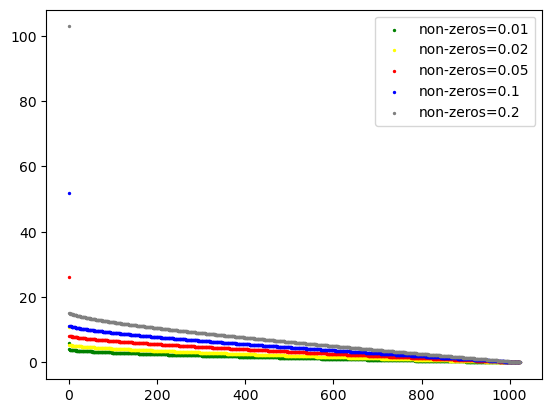

In [336]:
def draw_sigmas(sigmas):
    _, ax = plt.subplots()
    l = len(sigmas[0])
    ax.scatter([i for i in range(l)], sigmas[0], color='green', s=2, label="non-zeros=0.01")
    ax.scatter([i for i in range(l)], sigmas[1], color='yellow', s=2, label="non-zeros=0.02")
    ax.scatter([i for i in range(l)], sigmas[2], color='red', s=2, label="non-zeros=0.05")
    ax.scatter([i for i in range(l)], sigmas[3], color='blue', s=2, label="non-zeros=0.1")
    ax.scatter([i for i in range(l)], sigmas[4], color='grey', s=2, label="non-zeros=0.2")
    ax.legend()
    plt.show()


sigmas = [randomized_svd(m, n_components=k)[1] for m in test_matrices]
draw_sigmas(sigmas)

In [337]:
from time import perf_counter
import pandas as pd

df = pd.DataFrame(columns=['non-zeros', 'b', 'sigma', 'time', 'error'])
trees = {}

for index, m in enumerate(test_matrices):
    for b, sigma, sigma_str in \
            [(1, sigmas[index][1], 'sigmas[1]'), (1, sigmas[index][k//2], 'sigmas[k/2]'), (1, sigmas[index][k - 1], 'sigmas[k-1]'), 
             (4, sigmas[index][1], 'sigmas[1]'),  (4, sigmas[index][k//2], 'sigmas[k/2]'), (4, sigmas[index][k - 1], 'sigmas[k-1]')]:
        root = MatrixTree(m, 0, k, 0, k)
        start = perf_counter()
        root.compress(b, sigma)
        end = perf_counter()
        output_matrix = np.zeros(test_matrices[index].shape)
        root.decompress(output_matrix)
        new_row = {'non-zeros': ratios[index], 'b': b, 'sigma': sigma_str, 'time': end - start, 'error': np.linalg.norm(output_matrix - test_matrices[index])}
        df.loc[len(df)] = new_row
        trees[(index, b, sigma_str)] = root


### Czas kompresji macierzy i dokładność.

In [338]:
print(df.to_string(float_format=lambda _: '{:.3f}'.format(_), index=False))

 non-zeros  b       sigma    time   error
     0.010  1   sigmas[1]   0.027  58.749
     0.010  1 sigmas[k/2]   0.661  51.041
     0.010  1 sigmas[k-1]   9.592   0.000
     0.010  4   sigmas[1]   0.034  58.363
     0.010  4 sigmas[k/2]   0.613  44.828
     0.010  4 sigmas[k-1]   3.323   0.000
     0.020  1   sigmas[1]   0.030  82.816
     0.020  1 sigmas[k/2]   0.465  76.435
     0.020  1 sigmas[k-1]  14.223   0.000
     0.020  4   sigmas[1]   0.032  82.328
     0.020  4 sigmas[k/2]   0.307  74.964
     0.020  4 sigmas[k-1]   4.766   0.000
     0.050  1   sigmas[1]   0.023 129.118
     0.050  1 sigmas[k/2]   0.281 125.653
     0.050  1 sigmas[k-1]  71.145   0.000
     0.050  4   sigmas[1]   0.069 128.378
     0.050  4 sigmas[k/2]   0.783 119.434
     0.050  4 sigmas[k-1]  21.712   0.000
     0.100  1   sigmas[1]   0.033 179.195
     0.100  1 sigmas[k/2]   0.345 175.143
     0.100  1 sigmas[k-1]  99.366   0.000
     0.100  4   sigmas[1]   0.037 178.191
     0.100  4 sigmas[k/2]   0.363 

### Wizualizacja skompresowanych macierzy

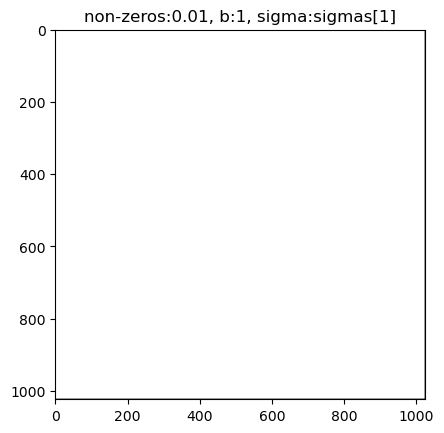

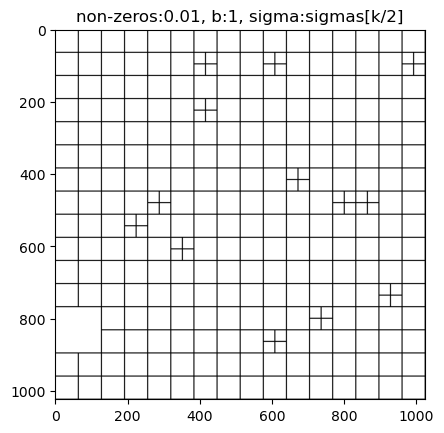

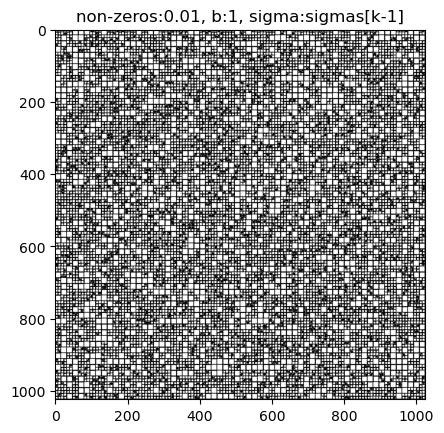

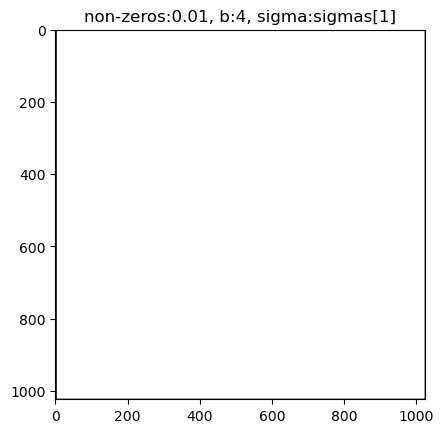

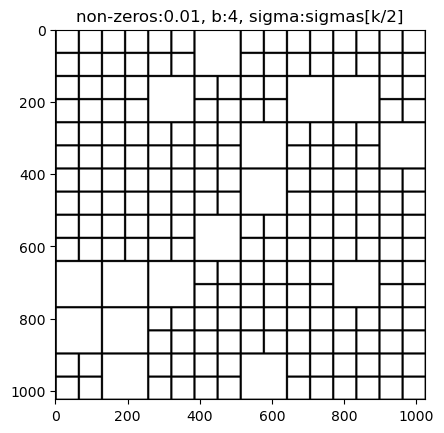

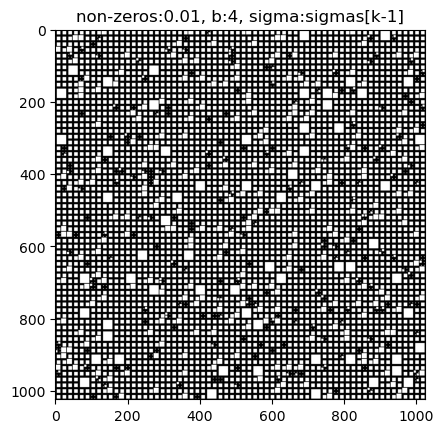

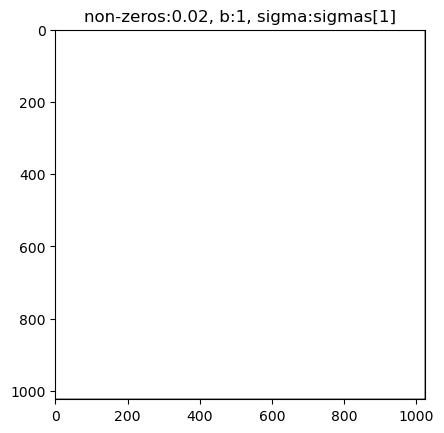

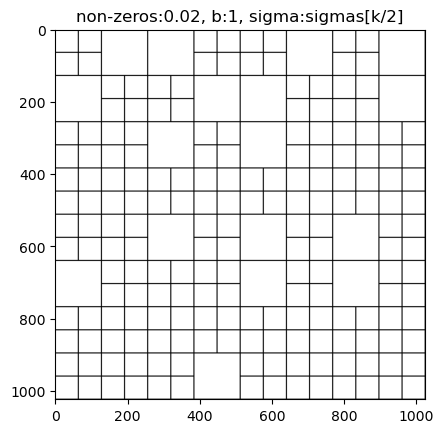

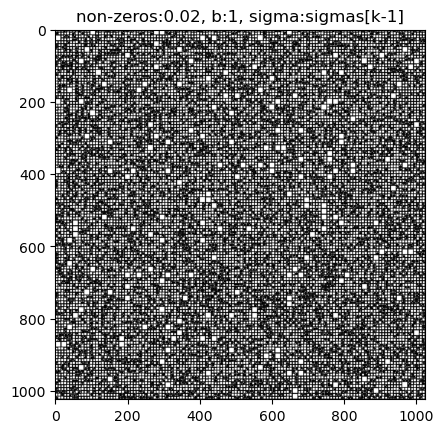

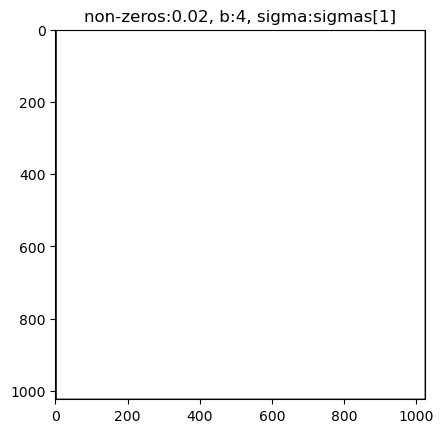

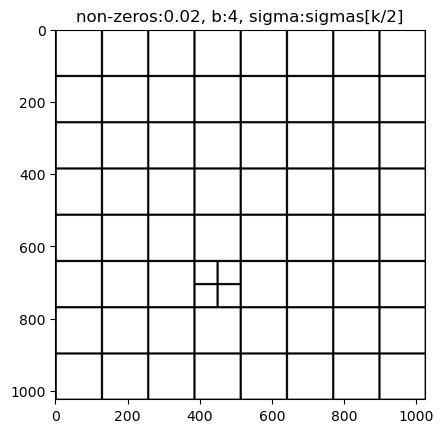

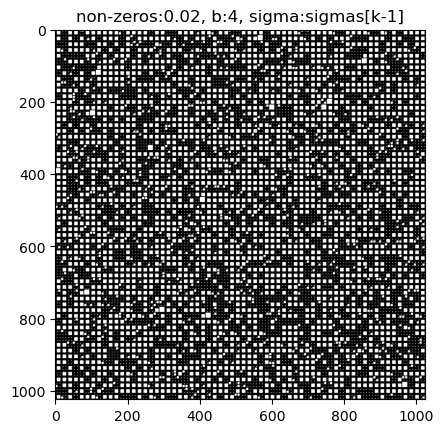

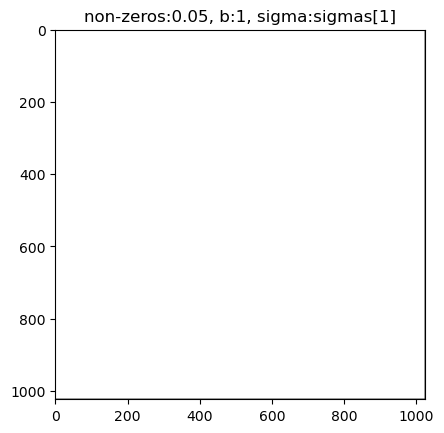

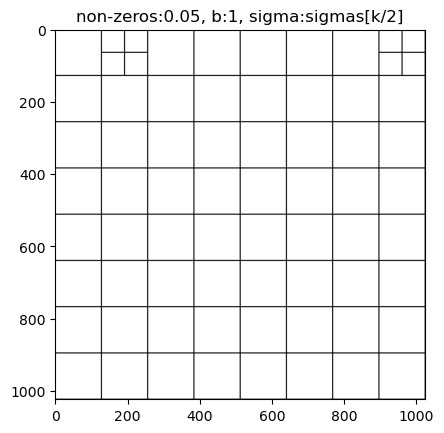

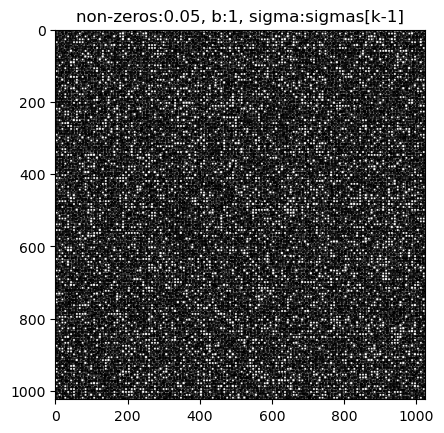

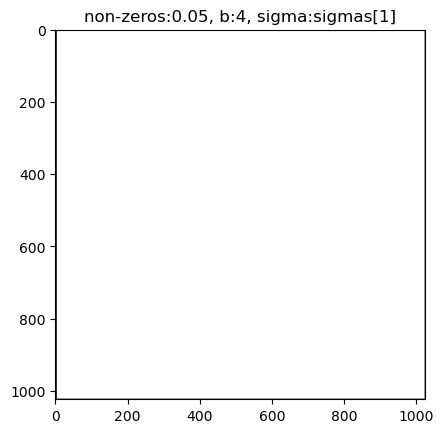

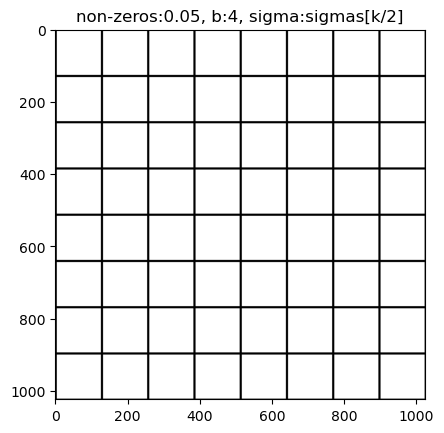

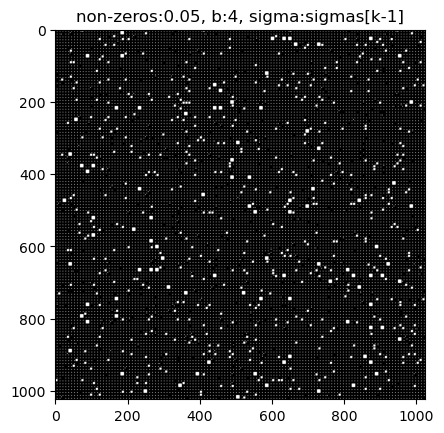

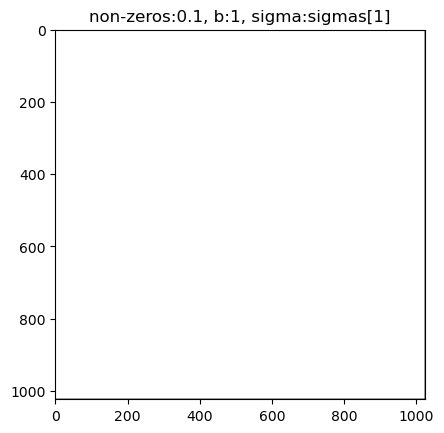

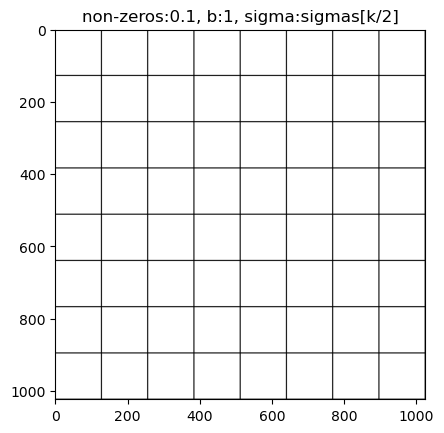

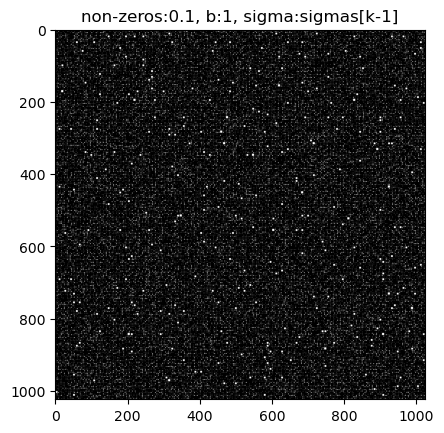

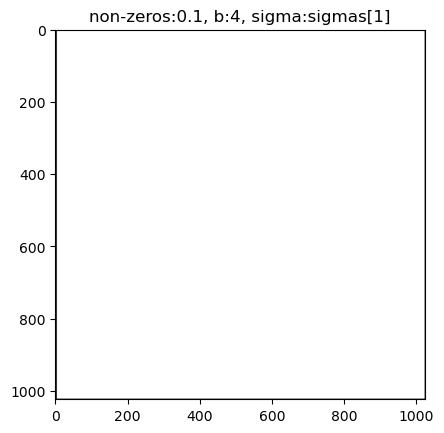

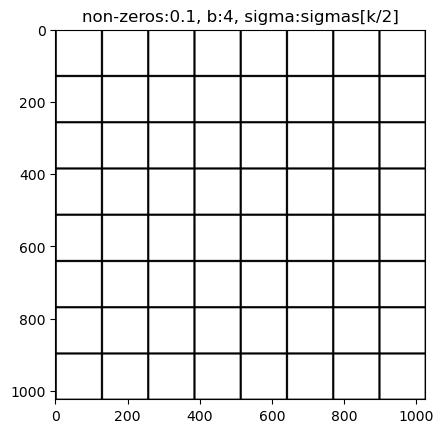

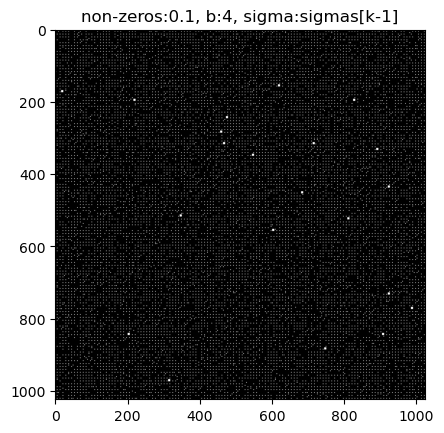

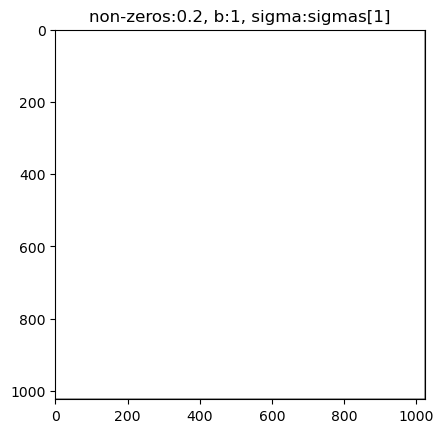

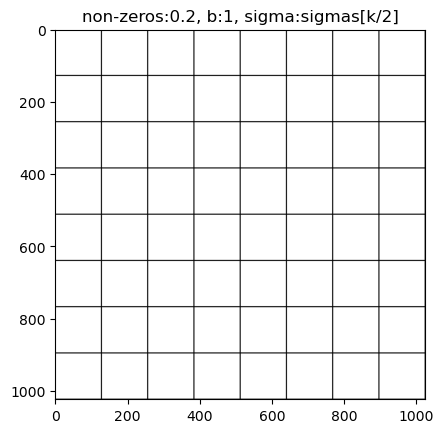

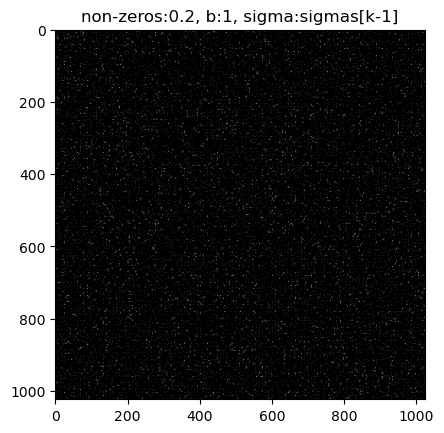

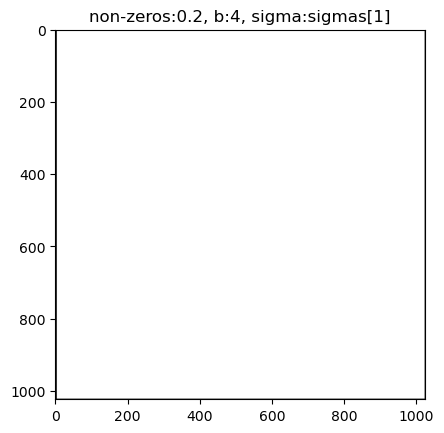

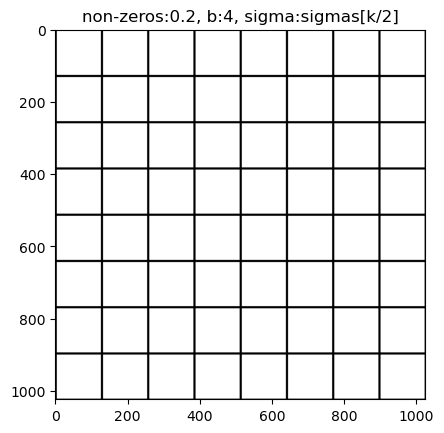

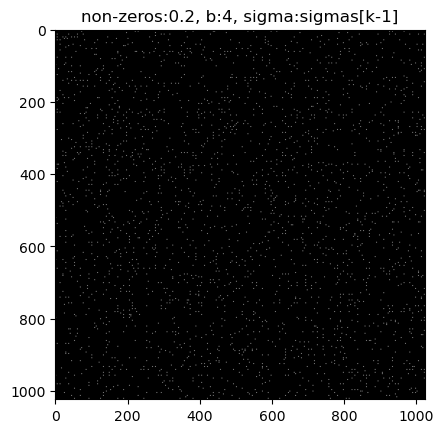

In [339]:
for index, b, sigma in trees:
    draw_tree(trees[(index, b, sigma)], title=f'non-zeros:{ratios[index]}, b:{b}, sigma:{sigma}') 

### Wnioski